In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import plotly.express as px
from shapely.geometry import Point
from shapely.ops import nearest_points
import cartopy.crs as ccrs
import geopandas as gpd
import pandas as pd
import numpy as np
import copy
import json
import scipy
from shapely import wkt

In [ ]:
file = open("Data/final_demand_gtap.json", "r")
final_demand_gtap = file.read()
final_demand_gtap = json.loads(final_demand_gtap)
Countries = list(final_demand_gtap.keys())

In [ ]:
# Read simulation results
wholeworld = gpd.read_file('Data/output_wholeworld/wholeworld_bio.shp')
wholeworld = gpd.GeoDataFrame(wholeworld)

production_concentration_gtap = pd.read_csv('Data/Production_concentrations_gtap.csv',index_col=0)

production_concentration_gtap_sum = production_concentration_gtap.sum(axis=1)

# The total concentrations from bioburn emissions.
bio_conc = pd.read_csv("Data/bio_concentrations.csv")

# The total concentrations from ROAD sectors.
road_conc = pd.read_csv("Data/road_concentrations.csv")

total_conc_gtap = [a + b + c for a, b, c in zip(production_concentration_gtap_sum, road_conc['TotalPM25'], bio_conc['TotalPM25'])]

wholeworld['Simulated_PM2.5'] = total_conc_gtap

country_classify = pd.read_csv("Data/country_classify.csv")

wholeworld['eora_area_fraction'] = country_classify['eora_area_fraction']
wholeworld['gtap_area_fraction'] = country_classify['gtap_area_fraction']

In [ ]:
wholeworld_final = wholeworld[['geometry','Simulated_PM2.5','eora_area_fraction','gtap_area_fraction']]

In [ ]:
# Read measurement files
AUS_final = pd.read_csv('Data/Final_PM25/AUS_final.csv')
AUS_final['geometry'] = AUS_final['geometry'].apply(wkt.loads)
AUS_final = gpd.GeoDataFrame(AUS_final,geometry='geometry')
AUS_final = AUS_final.set_crs(wholeworld.crs)

China_final = pd.read_csv('Data/Final_PM25/China_final.csv')
China_final['geometry'] = China_final['geometry'].apply(wkt.loads)
China_final = gpd.GeoDataFrame(China_final,geometry='geometry')
China_final = China_final.set_crs(wholeworld.crs)

USA_final = pd.read_csv('Data/Final_PM25/USA_final.csv')
USA_final['geometry'] = USA_final['geometry'].apply(wkt.loads)
USA_final = gpd.GeoDataFrame(USA_final,geometry='geometry')
USA_final = USA_final.set_crs(wholeworld.crs)

Canada_final = pd.read_csv('Data/Final_PM25/Canada_final.csv')
Canada_final['geometry'] = Canada_final['geometry'].apply(wkt.loads)
Canada_final = gpd.GeoDataFrame(Canada_final,geometry='geometry')
Canada_final = Canada_final.set_crs(wholeworld.crs)

Europe_final = pd.read_csv('Data/Final_PM25/Europe_final.csv')
Europe_final['geometry'] = Europe_final['geometry'].apply(wkt.loads)
Europe_final = gpd.GeoDataFrame(Europe_final,geometry='geometry')
Europe_final = Europe_final.set_crs(wholeworld.crs)

In [ ]:
wholeworld.geometry

,geometry
0,"POLYGON ((-180 -88, -175 -88, -175 -84, -180 -..."
1,"POLYGON ((-180 -84, -175 -84, -175 -80, -180 -..."
2,"POLYGON ((-180 -80, -175 -80, -175 -76, -180 -..."
3,"POLYGON ((-180 -76, -175 -76, -175 -72, -180 -..."
4,"POLYGON ((-180 -72, -175 -72, -175 -68, -180 -..."
...,...
273734,"POLYGON ((174.92188 -41.1875, 175 -41.1875, 17..."
273735,"POLYGON ((174.92188 -37.125, 175 -37.125, 175 ..."
273736,"POLYGON ((174.92188 -37.0625, 175 -37.0625, 17..."
273737,"POLYGON ((174.92188 -37, 175 -37, 175 -36.9375..."


In [ ]:
# Spatial join: add the polygon index to each point
# AUS_comparison = gpd.sjoin(AUS_final, wholeworld_final, how="inner", op='within')
# USA_comparison = gpd.sjoin(USA_final, wholeworld_final, how="inner", op='within')
# China_comparison = gpd.sjoin(China_final, wholeworld_final, how="inner", op='within')
# Europe_comparison = gpd.sjoin(Europe_final, wholeworld_final, how="inner", op='within')
# Canada_comparison = gpd.sjoin(Canada_final, wholeworld_final, how="inner", op='within')

AUS_comparison = gpd.sjoin(AUS_final, wholeworld_final, how="inner")
USA_comparison = gpd.sjoin(USA_final, wholeworld_final, how="inner")
China_comparison = gpd.sjoin(China_final, wholeworld_final, how="inner")
Europe_comparison = gpd.sjoin(Europe_final, wholeworld_final, how="inner")
Canada_comparison = gpd.sjoin(Canada_final, wholeworld_final, how="inner")

In [ ]:
# Calculate average PM2.5 for each polygon
avg_pm25 = AUS_comparison.groupby('index_right')['PM2.5'].mean().reset_index()

# Rename the columns appropriately
avg_pm25.rename(columns={'PM2.5': 'measure_pm2.5'}, inplace=True)

# Merge the average PM2.5 values back into the polygon dataframe
AUS_comparison_final = wholeworld_final.merge(avg_pm25, left_index=True, right_on='index_right', how='left')
AUS_comparison_final = AUS_comparison_final.dropna()

In [ ]:
# Calculate average PM2.5 for each polygon
avg_pm25 = Canada_comparison.groupby('index_right')['PM2.5'].mean().reset_index()

# Rename the columns appropriately
avg_pm25.rename(columns={'PM2.5': 'measure_pm2.5'}, inplace=True)

# Merge the average PM2.5 values back into the polygon dataframe
Canada_comparison_final = wholeworld_final.merge(avg_pm25, left_index=True, right_on='index_right', how='left')
Canada_comparison_final = Canada_comparison_final.dropna()

In [ ]:
# Calculate average PM2.5 for each polygon
avg_pm25 = Europe_comparison.groupby('index_right')['PM2.5'].mean().reset_index()

# Rename the columns appropriately
avg_pm25.rename(columns={'PM2.5': 'measure_pm2.5'}, inplace=True)

# Merge the average PM2.5 values back into the polygon dataframe
Europe_comparison_final = wholeworld_final.merge(avg_pm25, left_index=True, right_on='index_right', how='left')
Europe_comparison_final = Europe_comparison_final.dropna()

In [ ]:
# Calculate average PM2.5 for each polygon
avg_pm25 = China_comparison.groupby('index_right')['PM2.5'].mean().reset_index()

# Rename the columns appropriately
avg_pm25.rename(columns={'PM2.5': 'measure_pm2.5'}, inplace=True)

# Merge the average PM2.5 values back into the polygon dataframe
China_comparison_final = wholeworld_final.merge(avg_pm25, left_index=True, right_on='index_right', how='left')
China_comparison_final = China_comparison_final.dropna()

In [ ]:
# Calculate average PM2.5 for each polygon
avg_pm25 = USA_comparison.groupby('index_right')['PM2.5'].mean().reset_index()

# Rename the columns appropriately
avg_pm25.rename(columns={'PM2.5': 'measure_pm2.5'}, inplace=True)

# Merge the average PM2.5 values back into the polygon dataframe
USA_comparison_final = wholeworld_final.merge(avg_pm25, left_index=True, right_on='index_right', how='left')
USA_comparison_final = USA_comparison_final.dropna()

In [ ]:
AUS_comparison_final_new = AUS_comparison_final
China_comparison_final_new = China_comparison_final[(China_comparison_final['Simulated_PM2.5']>=2.4) & (China_comparison_final['Simulated_PM2.5']<=180)]
China_comparison_final_new = China_comparison_final_new[(China_comparison_final_new['measure_pm2.5']>=5) & (China_comparison_final_new['measure_pm2.5']<=200)]
USA_comparison_final_new = USA_comparison_final[(USA_comparison_final['Simulated_PM2.5']>=2.4)]
USA_comparison_final_new = USA_comparison_final_new[(USA_comparison_final_new['measure_pm2.5']>=2.4)]

Canada_comparison_final_new = Canada_comparison_final
Europe_comparison_final_new = Europe_comparison_final

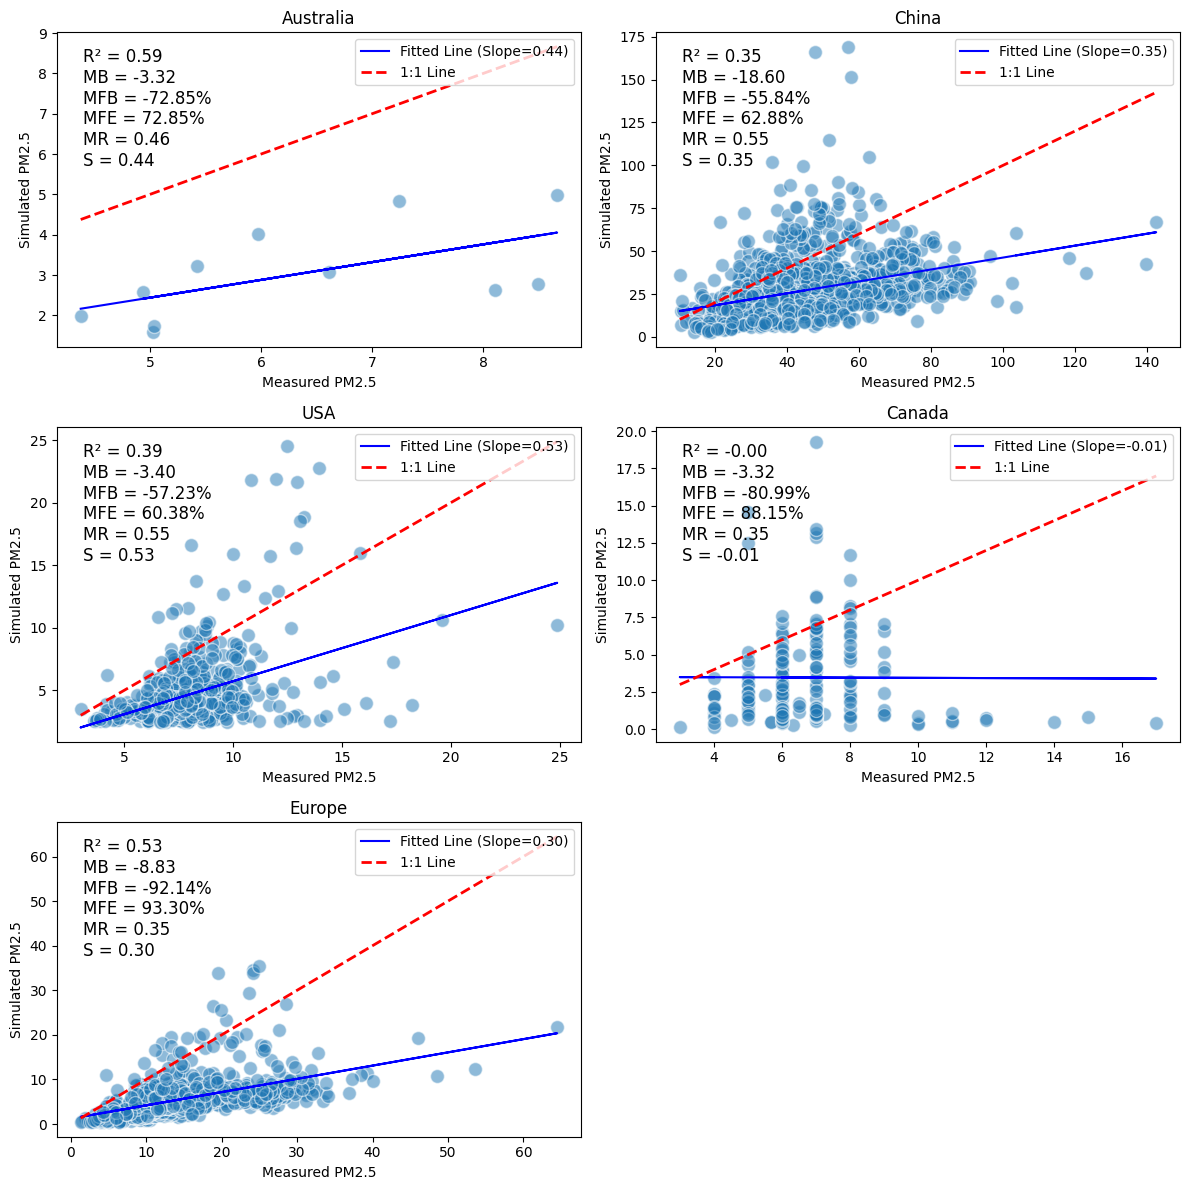

Australia:
   R²: 0.59
   Mean Bias: -3.32
   RMSE: 3.54
   RRMSE: 55.64
   Mean Fractional Bias: -72.85
   Mean Fractional Error: 72.85
   Model Ratio: 0.46
   Slope: 0.44
China:
   R²: 0.35
   Mean Bias: -18.60
   RMSE: 26.33
   RRMSE: 57.08
   Mean Fractional Bias: -55.84
   Mean Fractional Error: 62.88
   Model Ratio: 0.55
   Slope: 0.35
USA:
   R²: 0.39
   Mean Bias: -3.40
   RMSE: 4.30
   RRMSE: 52.74
   Mean Fractional Bias: -57.23
   Mean Fractional Error: 60.38
   Model Ratio: 0.55
   Slope: 0.53
Canada:
   R²: -0.00
   Mean Bias: -3.32
   RMSE: 4.97
   RRMSE: 73.28
   Mean Fractional Bias: -80.99
   Mean Fractional Error: 88.15
   Model Ratio: 0.35
   Slope: -0.01
Europe:
   R²: 0.53
   Mean Bias: -8.83
   RMSE: 10.54
   RRMSE: 73.61
   Mean Fractional Bias: -92.14
   Mean Fractional Error: 93.30
   Model Ratio: 0.35
   Slope: 0.30


In [ ]:
dataframes = [
    (AUS_comparison_final_new, "Australia"),
    (China_comparison_final_new, "China"),
    (USA_comparison_final_new, "USA"),
    (Canada_comparison_final_new, "Canada"),
    (Europe_comparison_final_new, "Europe")
]

# Function to plot and calculate evaluation metrics for a given dataframe
def plot_comparison_and_calculate_metrics(ax, df, title):
    x = df['measure_pm2.5']
    y = df['Simulated_PM2.5']

    # Calculate metrics
    diff = y - x
    mean_bias = np.mean(diff)
    rmse = np.sqrt(np.mean(diff**2))
    rrmse = rmse / np.mean(x) * 100  # Relative RMSE
    mean_error = np.mean(np.abs(diff))
    mean_fractional_bias = 100 * np.mean(2 * diff / (y + x))
    mean_fractional_error = 100 * np.mean(2 * np.abs(diff) / (np.abs(y) + np.abs(x)))
    model_ratio = np.exp(np.mean(np.log(y) - np.log(x)))
    slope, intercept = np.polyfit(x, y, 1)

    # Calculate R-squared value
    r2 = x.corr(y)

    # Create the plot
    ax.scatter(x, y, alpha=0.5, edgecolors='w', s=100)

    # Plot the line of best fit
    ax.plot(x, slope * x + intercept, color='b', linestyle='-', label=f'Fitted Line (Slope={slope:.2f})')

    # Plot the line of 1:1
    ax.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', lw=2, label='1:1 Line')


    # Annotate evaluation metrics on the plot
    text = (f'R² = {r2:.2f}\n'
            f'MB = {mean_bias:.2f}\n'
            # f'RMSE = {rmse:.2f}\n'
            # f'RRMSE = {rrmse:.2f}%\n'
            f'MFB = {mean_fractional_bias:.2f}%\n'
            f'MFE = {mean_fractional_error:.2f}%\n'
            f'MR = {model_ratio:.2f}\n'
            f'S = {slope:.2f}')
    ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=12, verticalalignment='top')

    # Set plot labels and title
    ax.set_xlabel('Measured PM2.5')
    ax.set_ylabel('Simulated PM2.5')
    ax.set_title(title)
    # Add legend
    ax.legend(loc='upper right')

    return r2, mean_bias, rmse, rrmse, mean_fractional_bias, mean_fractional_error, model_ratio, slope

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Iterate over each dataframe and apply the function
evaluation_metrics = {}
for i, (df, title) in enumerate(dataframes):
    r2, mb, rmse, rrmse, mfb, mfe, mr, s = plot_comparison_and_calculate_metrics(axs[i], df, title)
    evaluation_metrics[title] = {'R²': r2, 'Mean Bias': mb, 'RMSE': rmse, 'RRMSE': rrmse, 'Mean Fractional Bias': mfb, 'Mean Fractional Error': mfe, 'Model Ratio': mr, 'Slope': s}

# Remove the empty subplot if there's any
if len(dataframes) % 2 != 0:
    fig.delaxes(axs[-1])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print evaluation metrics for each dataframe
for region, metrics in evaluation_metrics.items():
    print(f"{region}:")
    for metric, value in metrics.items():
        print(f"   {metric}: {value:.2f}")


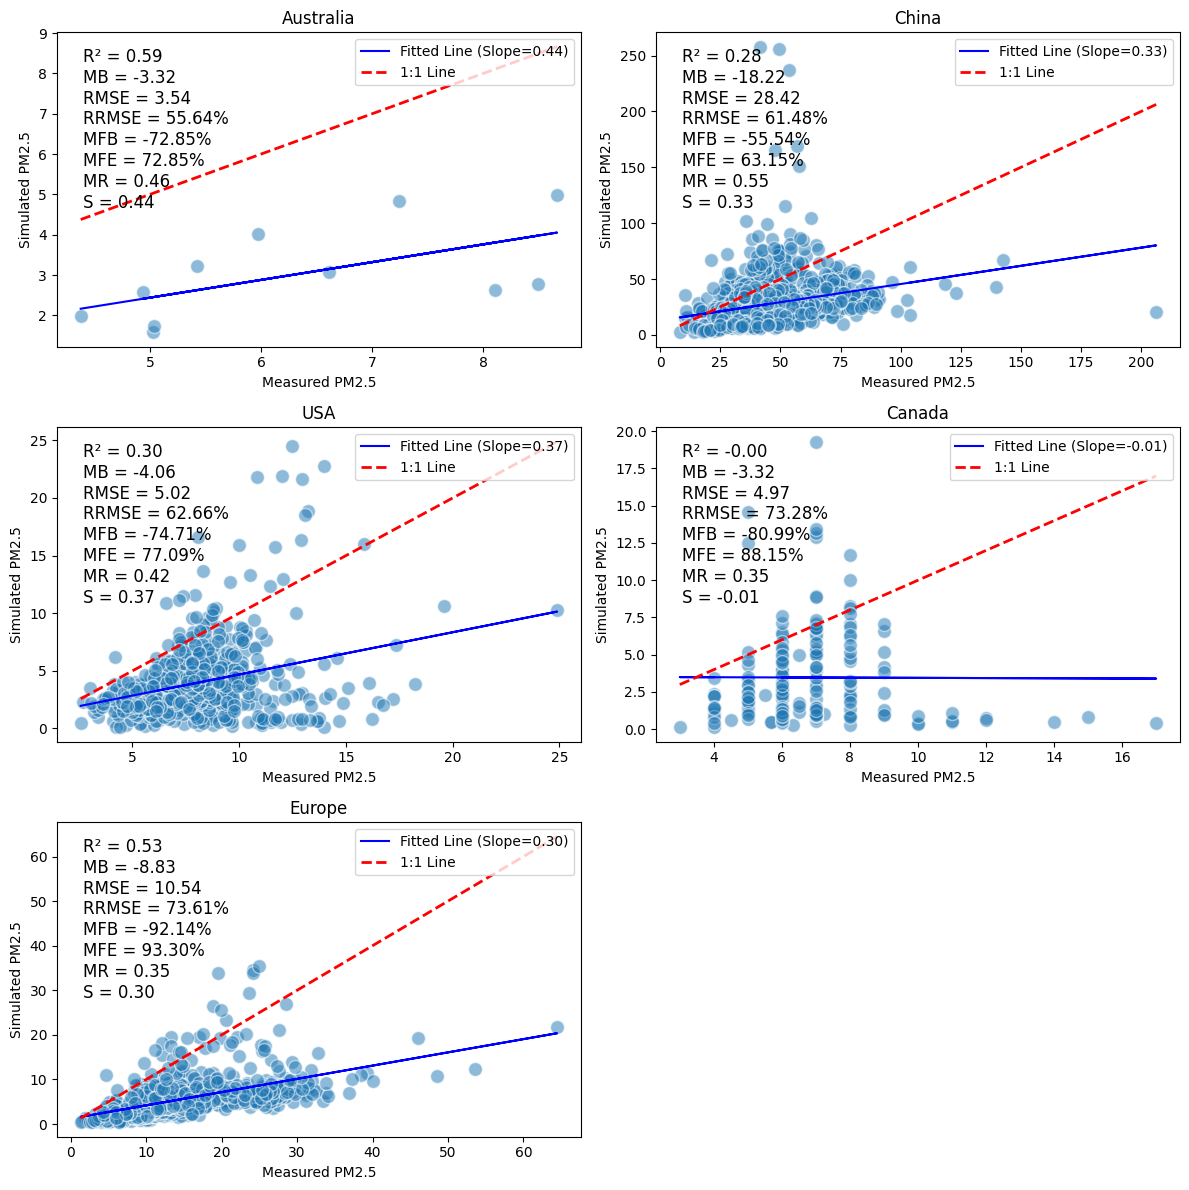

Australia:
   R²: 0.59
   Mean Bias: -3.32
   RMSE: 3.54
   RRMSE: 55.64
   Mean Fractional Bias: -72.85
   Mean Fractional Error: 72.85
   Model Ratio: 0.46
   Slope: 0.44
China:
   R²: 0.28
   Mean Bias: -18.22
   RMSE: 28.42
   RRMSE: 61.48
   Mean Fractional Bias: -55.54
   Mean Fractional Error: 63.15
   Model Ratio: 0.55
   Slope: 0.33
USA:
   R²: 0.30
   Mean Bias: -4.06
   RMSE: 5.02
   RRMSE: 62.66
   Mean Fractional Bias: -74.71
   Mean Fractional Error: 77.09
   Model Ratio: 0.42
   Slope: 0.37
Canada:
   R²: -0.00
   Mean Bias: -3.32
   RMSE: 4.97
   RRMSE: 73.28
   Mean Fractional Bias: -80.99
   Mean Fractional Error: 88.15
   Model Ratio: 0.35
   Slope: -0.01
Europe:
   R²: 0.53
   Mean Bias: -8.83
   RMSE: 10.54
   RRMSE: 73.61
   Mean Fractional Bias: -92.14
   Mean Fractional Error: 93.30
   Model Ratio: 0.35
   Slope: 0.30


In [ ]:
dataframes = [
    (AUS_comparison_final, "Australia"),
    (China_comparison_final, "China"),
    (USA_comparison_final, "USA"),
    (Canada_comparison_final, "Canada"),
    (Europe_comparison_final, "Europe")
]

# Function to plot and calculate evaluation metrics for a given dataframe
def plot_comparison_and_calculate_metrics(ax, df, title):
    x = df['measure_pm2.5']
    y = df['Simulated_PM2.5']

    # Calculate metrics
    diff = y - x
    mean_bias = np.mean(diff)
    rmse = np.sqrt(np.mean(diff**2))
    rrmse = rmse / np.mean(x) * 100  # Relative RMSE
    mean_error = np.mean(np.abs(diff))
    mean_fractional_bias = 100 * np.mean(2 * diff / (y + x))
    mean_fractional_error = 100 * np.mean(2 * np.abs(diff) / (np.abs(y) + np.abs(x)))
    model_ratio = np.exp(np.mean(np.log(y) - np.log(x)))
    slope, intercept = np.polyfit(x, y, 1)

    # Calculate R-squared value
    r2 = x.corr(y)

    # Create the plot
    ax.scatter(x, y, alpha=0.5, edgecolors='w', s=100)

    # Plot the line of best fit
    ax.plot(x, slope * x + intercept, color='b', linestyle='-', label=f'Fitted Line (Slope={slope:.2f})')

    # Plot the line of 1:1
    ax.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', lw=2, label='1:1 Line')


    # Annotate evaluation metrics on the plot
    text = (f'R² = {r2:.2f}\n'
            f'MB = {mean_bias:.2f}\n'
            # f'RMSE = {rmse:.2f}\n'
            # f'RRMSE = {rrmse:.2f}%\n'
            f'MFB = {mean_fractional_bias:.2f}%\n'
            f'MFE = {mean_fractional_error:.2f}%\n'
            f'MR = {model_ratio:.2f}\n'
            f'S = {slope:.2f}')
    ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=12, verticalalignment='top')

    # Set plot labels and title
    ax.set_xlabel('Measured PM2.5')
    ax.set_ylabel('Simulated PM2.5')
    ax.set_title(title)
    # Add legend
    ax.legend(loc='upper right')

    return r2, mean_bias, rmse, rrmse, mean_fractional_bias, mean_fractional_error, model_ratio, slope

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Iterate over each dataframe and apply the function
evaluation_metrics = {}
for i, (df, title) in enumerate(dataframes):
    r2, mb, rmse, rrmse, mfb, mfe, mr, s = plot_comparison_and_calculate_metrics(axs[i], df, title)
    evaluation_metrics[title] = {'R²': r2, 'Mean Bias': mb, 'RMSE': rmse, 'RRMSE': rrmse, 'Mean Fractional Bias': mfb, 'Mean Fractional Error': mfe, 'Model Ratio': mr, 'Slope': s}

# Remove the empty subplot if there's any
if len(dataframes) % 2 != 0:
    fig.delaxes(axs[-1])

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Print evaluation metrics for each dataframe
for region, metrics in evaluation_metrics.items():
    print(f"{region}:")
    for metric, value in metrics.items():
        print(f"   {metric}: {value:.2f}")


---

In [ ]:
WHO = pd.read_csv('Data/WHO_PM25.csv')

In [ ]:
WHO['Year'].unique()

array([2013, 2015, 2017, 2016, 2014, 2012, 2010, 2009, 2008, 2011])

In [ ]:
# Read simulation results
World_Cities = gpd.read_file('Data/World_Cities/World_Cities.shp')
World_Cities = gpd.GeoDataFrame(World_Cities)

In [ ]:
World_Cities = World_Cities[['CNTRY_NAME','CITY_NAME','geometry']]
World_Cities.columns = ['Country','City/Town','geometry']

In [ ]:
# World_Cities['geometry'] = World_Cities.geometry.to_crs(epsg=3857).buffer(5000)  # 10 km buffer
# World_Cities = World_Cities.to_crs(epsg=4326)

In [ ]:
merged_df = pd.merge(World_Cities, WHO, on=['Country', 'City/Town'], how='inner')

In [ ]:
merged_df['Year'].unique()

array([2016, 2014, 2017, 2010, 2015, 2013, 2011, 2012, 2008, 2009])

In [ ]:
wholeworld_final = wholeworld_final.to_crs(World_Cities.crs)

In [ ]:
Other_comparison = gpd.sjoin(merged_df, wholeworld_final, how="inner")

In [ ]:
Other_comparison = Other_comparison[Other_comparison['Year'].isin([2016,2017])]

In [ ]:
len(Other_comparison['index_right'].unique())

255

In [ ]:
# Other_comparison = Other_comparison.groupby('geometry')[['Simulated_PM2.5','Annual mean, ug/m3']].mean().reset_index()
# Other_comparison['measure_pm2.5'] = Other_comparison['Annual mean, ug/m3']

In [ ]:
# Other_comparison['Year'].unique()

In [ ]:
# Calculate average PM2.5 for each polygon
avg_pm25 = Other_comparison.groupby('index_right')['Annual mean, ug/m3'].mean().reset_index()

# Rename the columns appropriately
avg_pm25.rename(columns={'Annual mean, ug/m3': 'measure_pm2.5'}, inplace=True)

# Merge the average PM2.5 values back into the polygon dataframe
Other_comparison_final = wholeworld_final.merge(avg_pm25, left_index=True, right_on='index_right', how='left')
Other_comparison_final = Other_comparison_final.dropna()

(np.float64(0.44107090935040005),
 np.float64(-11.554831163427716),
 np.float64(27.577574479441868),
 np.float64(107.54368393114659),
 np.float64(-80.4602863429093),
 np.float64(90.41112889645743),
 np.float64(0.38996875611878623),
 np.float64(0.3670331745993145))

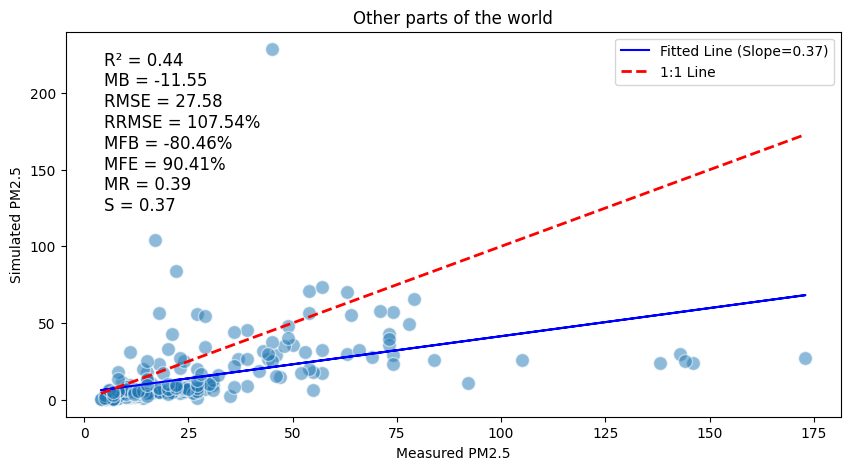

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_comparison_and_calculate_metrics(ax, Other_comparison_final, 'Other parts of the world')

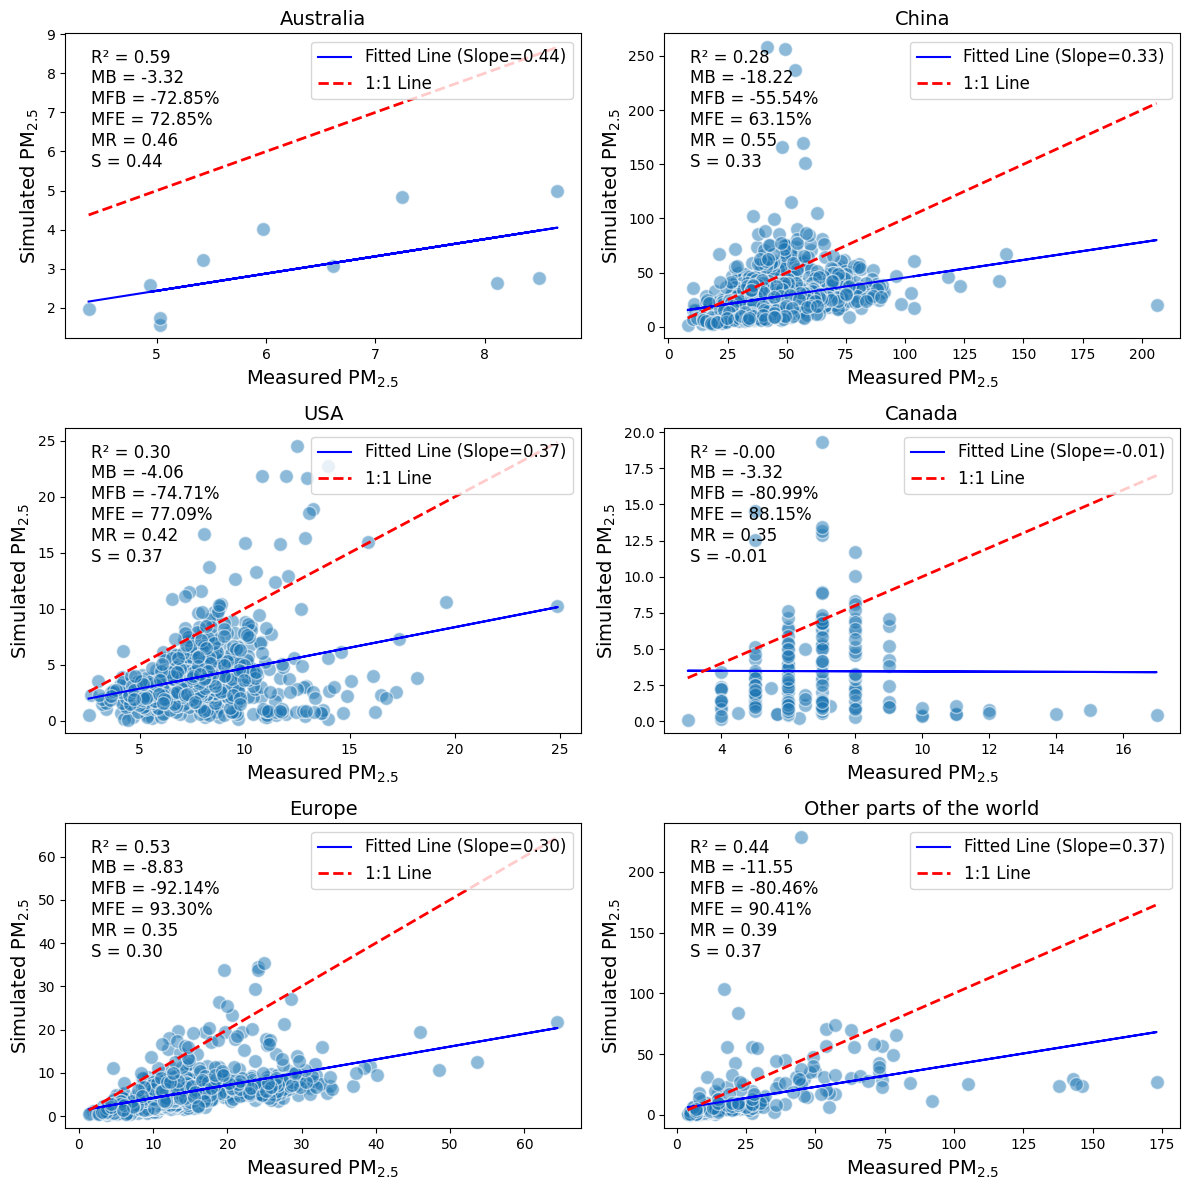

Australia:
   R²: 0.59
   Mean Bias: -3.32
   Mean Fractional Bias: -72.85
   Mean Fractional Error: 72.85
   Model Ratio: 0.46
   Slope: 0.44
China:
   R²: 0.28
   Mean Bias: -18.22
   Mean Fractional Bias: -55.54
   Mean Fractional Error: 63.15
   Model Ratio: 0.55
   Slope: 0.33
USA:
   R²: 0.30
   Mean Bias: -4.06
   Mean Fractional Bias: -74.71
   Mean Fractional Error: 77.09
   Model Ratio: 0.42
   Slope: 0.37
Canada:
   R²: -0.00
   Mean Bias: -3.32
   Mean Fractional Bias: -80.99
   Mean Fractional Error: 88.15
   Model Ratio: 0.35
   Slope: -0.01
Europe:
   R²: 0.53
   Mean Bias: -8.83
   Mean Fractional Bias: -92.14
   Mean Fractional Error: 93.30
   Model Ratio: 0.35
   Slope: 0.30
Other parts of the world:
   R²: 0.44
   Mean Bias: -11.55
   Mean Fractional Bias: -80.46
   Mean Fractional Error: 90.41
   Model Ratio: 0.39
   Slope: 0.37


In [ ]:
dataframes = [
    (AUS_comparison_final, "Australia"),
    (China_comparison_final, "China"),
    (USA_comparison_final, "USA"),
    (Canada_comparison_final, "Canada"),
    (Europe_comparison_final, "Europe"),
    (Other_comparison_final, 'Other parts of the world')
]

# Function to plot and calculate evaluation metrics for a given dataframe
def plot_comparison_and_calculate_metrics(ax, df, title):
    x = df['measure_pm2.5']
    y = df['Simulated_PM2.5']

    # Calculate metrics
    diff = y - x
    mean_bias = np.mean(diff)
    mean_error = np.mean(np.abs(diff))
    mean_fractional_bias = 100 * np.mean(2 * diff / (y + x))
    mean_fractional_error = 100 * np.mean(2 * np.abs(diff) / (np.abs(y) + np.abs(x)))
    model_ratio = np.exp(np.mean(np.log(y) - np.log(x)))
    slope, intercept = np.polyfit(x, y, 1)

    # Calculate R-squared value
    r2 = x.corr(y)

    # Create the plot
    ax.scatter(x, y, alpha=0.5, edgecolors='w', s=100)

    # Plot the line of best fit
    ax.plot(x, slope * x + intercept, color='b', linestyle='-', label=f'Fitted Line (Slope={slope:.2f})')

    # Plot the line of 1:1
    ax.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', lw=2, label='1:1 Line')


    # Annotate evaluation metrics on the plot
    text = (f'R² = {r2:.2f}\n'
            f'MB = {mean_bias:.2f}\n'
            f'MFB = {mean_fractional_bias:.2f}%\n'
            f'MFE = {mean_fractional_error:.2f}%\n'
            f'MR = {model_ratio:.2f}\n'
            f'S = {slope:.2f}')
    ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=12, verticalalignment='top')

    # Set plot labels and title
    ax.set_xlabel('Measured PM$_{2.5}$',fontsize=14)
    ax.set_ylabel('Simulated PM$_{2.5}$',fontsize=14)
    ax.set_title(title,fontsize=14)
    # Add legend
    ax.legend(loc='upper right',fontsize=12)

    return r2, mean_bias, mean_fractional_bias, mean_fractional_error, model_ratio, slope

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Iterate over each dataframe and apply the function
evaluation_metrics = {}
for i, (df, title) in enumerate(dataframes):
    r2, mb,  mfb, mfe, mr, s = plot_comparison_and_calculate_metrics(axs[i], df, title)
    evaluation_metrics[title] = {'R²': r2, 'Mean Bias': mb,  'Mean Fractional Bias': mfb, 'Mean Fractional Error': mfe, 'Model Ratio': mr, 'Slope': s}

# Remove the empty subplot if there's any
if len(dataframes) % 2 != 0:
    fig.delaxes(axs[-1])

# Adjust layout
plt.tight_layout()

# Show the plot
# Save the figure as a PDF
plt.savefig("Measurement_simulation1.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print evaluation metrics for each dataframe
for region, metrics in evaluation_metrics.items():
    print(f"{region}:")
    for metric, value in metrics.items():
        print(f"   {metric}: {value:.2f}")


### New WHO data

In [ ]:
WHO_new = pd.read_excel('Data/who_ambient_air_quality_database_version_2024.xlsx',sheet_name='Update 2024 (V6.1)')

In [ ]:
WHO_new_2017 = WHO_new[WHO_new['year']==2017]

In [ ]:
# WHO_new_2017 = WHO_new_2017[WHO_new_2017['type_of_stations'].notna()]

In [ ]:
# Create geometry column from lat/lon
WHO_new_2017['geometry'] = WHO_new_2017.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Convert to GeoDataFrame (assuming CRS is WGS84)
WHO_gdf = gpd.GeoDataFrame(WHO_new_2017, geometry='geometry', crs='EPSG:4326')

<ipython-input-171-62d250cba163>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WHO_new_2017['geometry'] = WHO_new_2017.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)


In [ ]:
# Ensure CRS is the same (assuming EPSG:4326, if not, replace accordingly)
wholeworld_final = wholeworld_final.to_crs('EPSG:4326')

In [ ]:
joined_df = gpd.sjoin(WHO_gdf, wholeworld_final[['geometry', 'Simulated_PM2.5']], how='left', predicate='within')

In [ ]:
# Calculate average PM2.5 for each polygon
avg_pm25 = joined_df.groupby('index_right')['pm25_concentration'].mean().reset_index()

# Rename the columns appropriately
avg_pm25.rename(columns={'pm25_concentration': 'measure_pm2.5'}, inplace=True)

In [ ]:
# Merge the average PM2.5 values back into the polygon dataframe
joined_df = wholeworld_final.merge(avg_pm25, left_index=True, right_on='index_right', how='left')
joined_df = joined_df.dropna()

In [ ]:
filtered_df = joined_df[(joined_df['Simulated_PM2.5'] <= 150) & (joined_df['Simulated_PM2.5'] >= 5)]
filtered_df = filtered_df[(filtered_df['measure_pm2.5'] <= 150) & (filtered_df['measure_pm2.5'] >= 5)]

In [ ]:
# joined_df = joined_df[['latitude', 'longitude', 'pm25_concentration', 'Simulated_PM2.5']]
# joined_df = joined_df.dropna()
# joined_df.columns = ['latitude','longitude','measure_pm2.5','Simulated_PM2.5']

(np.float64(0.5240085470593011),
 np.float64(-12.373628222203433),
 np.float64(-60.47812315171055),
 np.float64(69.32650719889115),
 np.float64(0.5163026171316798),
 np.float64(0.4123106820617981))

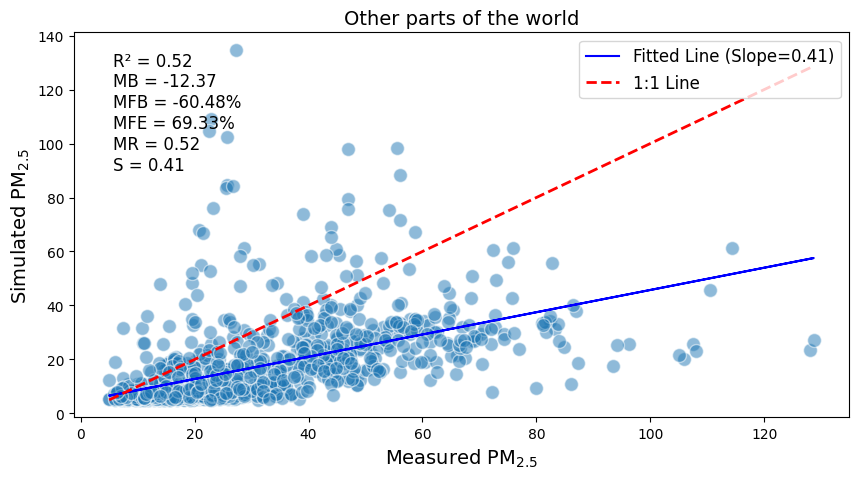

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_comparison_and_calculate_metrics(ax, filtered_df, 'Other parts of the world')

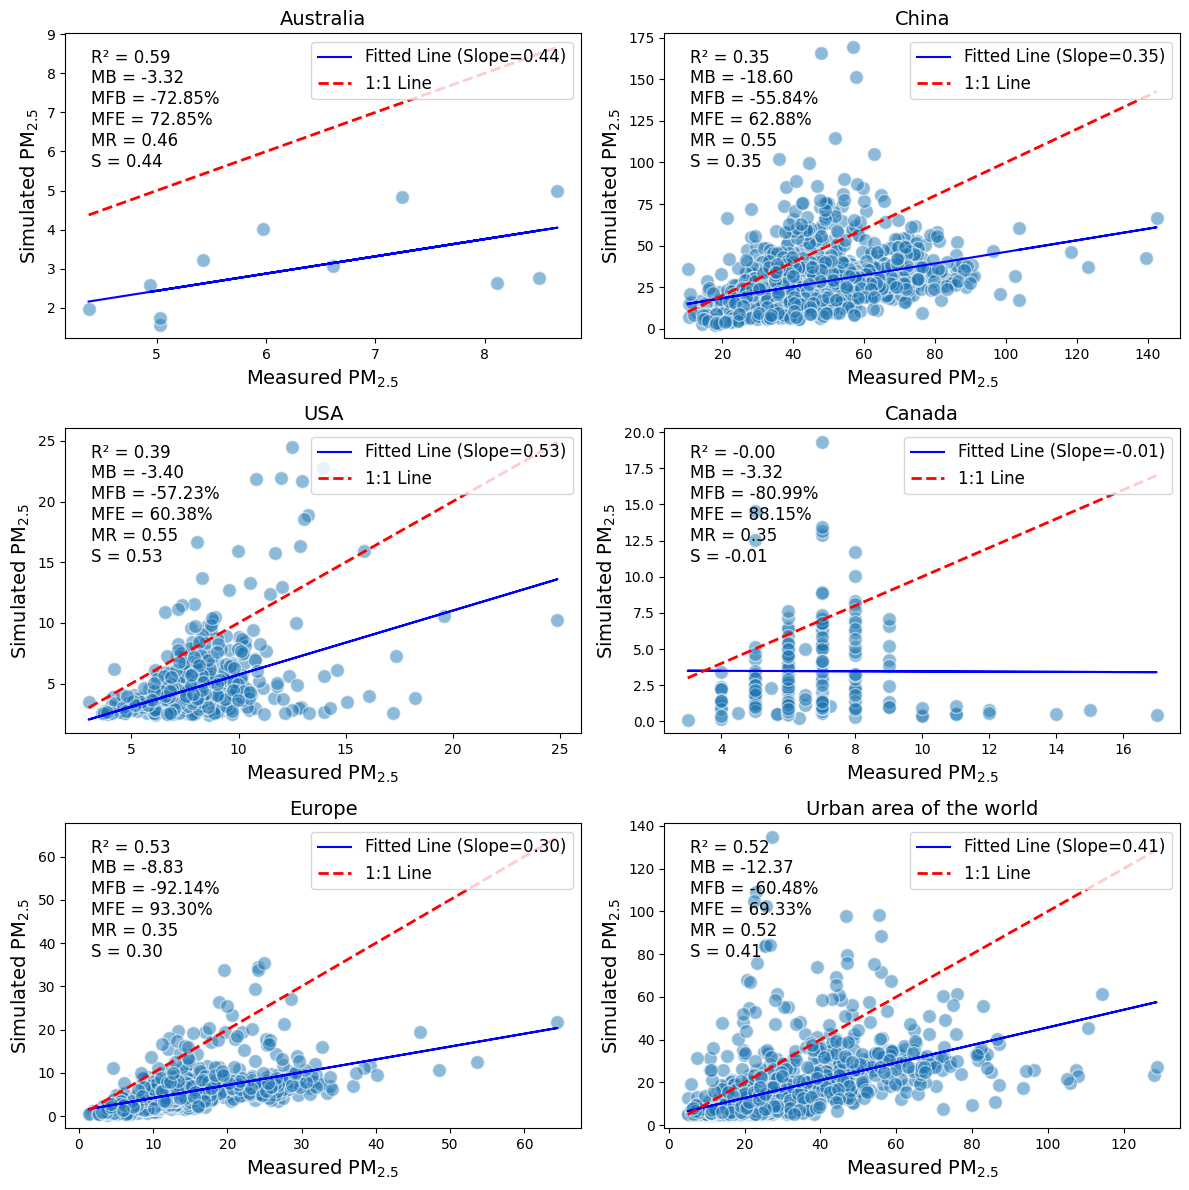

Australia:
   R²: 0.59
   Mean Bias: -3.32
   Mean Fractional Bias: -72.85
   Mean Fractional Error: 72.85
   Model Ratio: 0.46
   Slope: 0.44
China:
   R²: 0.35
   Mean Bias: -18.60
   Mean Fractional Bias: -55.84
   Mean Fractional Error: 62.88
   Model Ratio: 0.55
   Slope: 0.35
USA:
   R²: 0.39
   Mean Bias: -3.40
   Mean Fractional Bias: -57.23
   Mean Fractional Error: 60.38
   Model Ratio: 0.55
   Slope: 0.53
Canada:
   R²: -0.00
   Mean Bias: -3.32
   Mean Fractional Bias: -80.99
   Mean Fractional Error: 88.15
   Model Ratio: 0.35
   Slope: -0.01
Europe:
   R²: 0.53
   Mean Bias: -8.83
   Mean Fractional Bias: -92.14
   Mean Fractional Error: 93.30
   Model Ratio: 0.35
   Slope: 0.30
Urban area of the world:
   R²: 0.52
   Mean Bias: -12.37
   Mean Fractional Bias: -60.48
   Mean Fractional Error: 69.33
   Model Ratio: 0.52
   Slope: 0.41


In [ ]:
dataframes = [
    (AUS_comparison_final_new, "Australia"),
    (China_comparison_final_new, "China"),
    (USA_comparison_final_new, "USA"),
    (Canada_comparison_final_new, "Canada"),
    (Europe_comparison_final_new, "Europe"),
    (filtered_df, 'Urban area of the world')
]

# Function to plot and calculate evaluation metrics for a given dataframe
def plot_comparison_and_calculate_metrics(ax, df, title):
    x = df['measure_pm2.5']
    y = df['Simulated_PM2.5']

    # Calculate metrics
    diff = y - x
    mean_bias = np.mean(diff)
    mean_error = np.mean(np.abs(diff))
    mean_fractional_bias = 100 * np.mean(2 * diff / (y + x))
    mean_fractional_error = 100 * np.mean(2 * np.abs(diff) / (np.abs(y) + np.abs(x)))
    model_ratio = np.exp(np.mean(np.log(y) - np.log(x)))
    slope, intercept = np.polyfit(x, y, 1)

    # Calculate R-squared value
    r2 = x.corr(y)

    # Create the plot
    ax.scatter(x, y, alpha=0.5, edgecolors='w', s=100)

    # Plot the line of best fit
    ax.plot(x, slope * x + intercept, color='b', linestyle='-', label=f'Fitted Line (Slope={slope:.2f})')

    # Plot the line of 1:1
    ax.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', lw=2, label='1:1 Line')


    # Annotate evaluation metrics on the plot
    text = (f'R² = {r2:.2f}\n'
            f'MB = {mean_bias:.2f}\n'
            f'MFB = {mean_fractional_bias:.2f}%\n'
            f'MFE = {mean_fractional_error:.2f}%\n'
            f'MR = {model_ratio:.2f}\n'
            f'S = {slope:.2f}')
    ax.text(0.05, 0.95, text, transform=ax.transAxes, fontsize=12, verticalalignment='top')

    # Set plot labels and title
    ax.set_xlabel('Measured PM$_{2.5}$',fontsize=14)
    ax.set_ylabel('Simulated PM$_{2.5}$',fontsize=14)
    ax.set_title(title,fontsize=14)
    # Add legend
    ax.legend(loc='upper right',fontsize=12)

    return r2, mean_bias, mean_fractional_bias, mean_fractional_error, model_ratio, slope

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Iterate over each dataframe and apply the function
evaluation_metrics = {}
for i, (df, title) in enumerate(dataframes):
    r2, mb,  mfb, mfe, mr, s = plot_comparison_and_calculate_metrics(axs[i], df, title)
    evaluation_metrics[title] = {'R²': r2, 'Mean Bias': mb,  'Mean Fractional Bias': mfb, 'Mean Fractional Error': mfe, 'Model Ratio': mr, 'Slope': s}

# Remove the empty subplot if there's any
if len(dataframes) % 2 != 0:
    fig.delaxes(axs[-1])

# Adjust layout
plt.tight_layout()

# Show the plot
# Save the figure as a PDF
plt.savefig("Measurement_simulation1.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print evaluation metrics for each dataframe
for region, metrics in evaluation_metrics.items():
    print(f"{region}:")
    for metric, value in metrics.items():
        print(f"   {metric}: {value:.2f}")


## All points

In [ ]:
# Concatenate all point GeoDataFrames
all_points = pd.concat([AUS_comparison_final_new, USA_comparison_final_new, China_comparison_final_new, Europe_comparison_final_new, Canada_comparison_final_new,filtered_df], ignore_index=True)

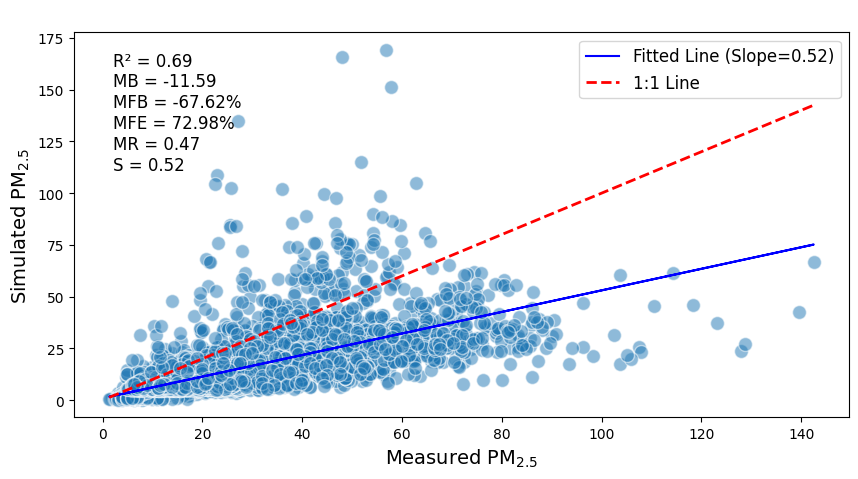

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_comparison_and_calculate_metrics(ax, all_points, '  ')
# Save the figure as a PDF
plt.savefig("Measurement_simulation2.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()